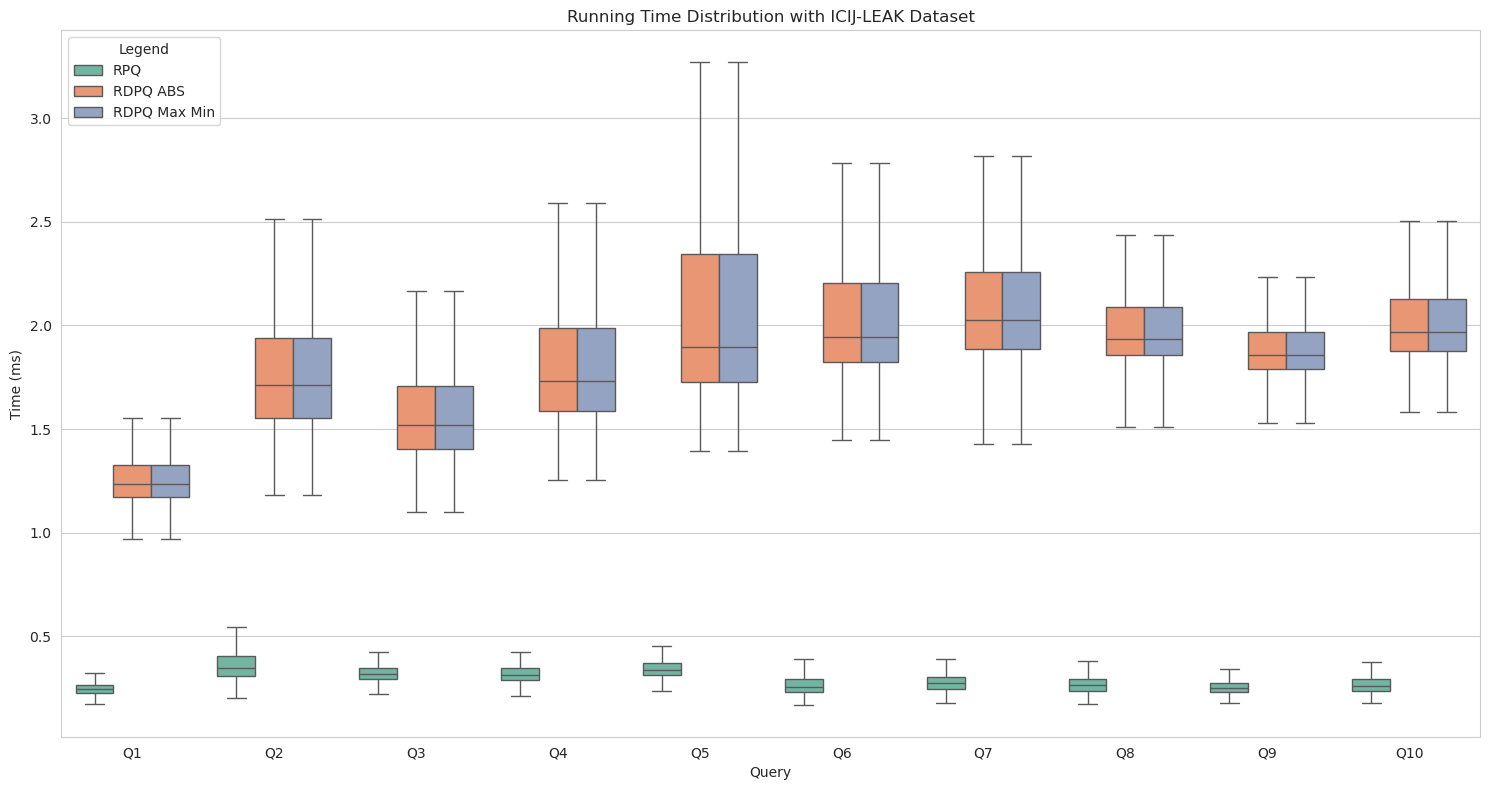

In [1]:
import pickle 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
with open("result/icij_static.pkl","rb+") as f:
    data_ytb = pickle.loads(f.read()) 

data_groups = []
for i in range(10):  # Q1-Q10
    id = 0
    for dtype in ["RPQ", "RDPQ ABS", "RDPQ Max Min"]:  # 3 种数据类型
        data = list(map(lambda x: x, data_ytb[i*3 + id][2])) # 乘1000转换为ms
        id = id + 1
        data_groups.append((f"Q{i+1}", dtype, data))
# 转换为 DataFrame
df_list = []
for group, dtype, values in data_groups:
    for v in values:
        df_list.append((group, dtype, v))
df = pd.DataFrame(df_list, columns=["Query", "Data Constraint", "Running Time"])

# 计算每组数据的平均值
mean_values = df.groupby(["Query", "Data Constraint"])["Running Time"].mean().reset_index()

# 设置绘图风格
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

# **改回线性坐标**
# plt.yscale("log")  # 移除对数坐标

# 绘制箱线图
ax = sns.boxplot(x="Query", y="Running Time", hue="Data Constraint", data=df, palette="Set2", showfliers=False)


# **调整 Y 轴单位（毫秒）**
plt.ylabel("Time (ms)")

# 调整图例
plt.legend(title="Legend", loc="upper left")

# 添加标题
plt.title("Running Time Distribution with ICIJ-LEAK Dataset")

# 旋转 X 轴标签
# plt.xticks(rotation=45)

# **自动调整布局，防止标签重叠**
plt.tight_layout()

# 显示图表
plt.show()

In [9]:
import pickle 
import numpy as np
import functools
with open("icij-leak/icij_leak_statistic.pkl","rb+") as f:
    data_ytb = pickle.loads(f.read()) 
with open("icij-leak-naive/icij_leak_naive_statistic.pkl","rb+") as f1:
    data_ytb1 = pickle.loads(f1.read()) 

for i in range(len(data_ytb)):
    print(f"{data_ytb[i][1]} query, the max time difference is {format(np.max(data_ytb[i][2])-np.max(data_ytb1[i][2]),'.3f')} ms, the average time difference  is {format(np.mean(data_ytb[i][2]-np.mean(data_ytb1[i][2])),'.3f')} ms")

REGEX Q0 query, the max time difference is 0.109 ms, the average time difference  is 0.002 ms
RDPQ Q11 query, the max time difference is -0.127 ms, the average time difference  is -0.014 ms
RDPQ Q12 query, the max time difference is 0.064 ms, the average time difference  is -0.009 ms
RDPQ Q13 query, the max time difference is -0.072 ms, the average time difference  is -0.018 ms
RDPQ Q14 query, the max time difference is 0.182 ms, the average time difference  is 0.043 ms
RDPQ Q15 query, the max time difference is 2.612 ms, the average time difference  is 5.406 ms
REGEX Q1 query, the max time difference is 0.716 ms, the average time difference  is 0.247 ms
RDPQ Q21 query, the max time difference is 4.779 ms, the average time difference  is 4.113 ms
RDPQ Q22 query, the max time difference is 3.906 ms, the average time difference  is 3.548 ms
RDPQ Q23 query, the max time difference is 3.454 ms, the average time difference  is 3.507 ms
RDPQ Q24 query, the max time difference is 2.660 ms, th

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def plot_max_comparison(path, path2, name1, name2, log_scale=True):
    # Load both datasets
    with open(path, "rb+") as f:
        data1 = pickle.loads(f.read())
    with open(path2, "rb+") as f:
        data2 = pickle.loads(f.read())
    
    # Process both datasets
    data_groups = []
    for dataset, name in [(data1, name1), (data2, name2)]:
        for i in range(12):  # Q1-Q10
            id = 0
            for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
                if id == 0:
                    id += 1
                    continue
                data = list(map(lambda x: x, dataset[i*6 + id][2]))
                id += 1
                data_groups.append((f"Q{i+1}", dtype, name, data))

    # Prepare max values for plotting
    plot_data = []
    for group, dtype, dataset_name, values in data_groups:
        plot_data.append({
            'Query': group,
            'Data Constraint': dtype,
            'Dataset': dataset_name,
            'Max': np.max(values)
        })
    df = pd.DataFrame(plot_data)
    
    # Create subplots
    num_queries = 12
    cols = 6
    rows = (num_queries + cols - 1) // cols
    plt.figure(figsize=(20, 6*rows))
    sns.set_style("whitegrid")

    for idx, query in enumerate(range(1, num_queries + 1), 1):
        ax = plt.subplot(rows, cols, idx)
        query_df = df[df['Query'] == f"Q{query}"]
        if query_df.empty:
            raise ValueError(f"No data available for Q{query}")
        # Plot max values as lines
        sns.lineplot(data=query_df, x='Data Constraint', y='Max', 
                    hue='Dataset', style='Dataset',
                    markers=True, dashes=False, ax=ax,
                    markersize=8, linewidth=2.5)
        ax.get_legend().remove() 
        
        ax.set_title(f"Max: {query}")
        ax.set_xlabel("Data Constraint")
        ax.set_ylabel("Time (ms)")
        plt.xticks(rotation=45)
        
        # Check for log scale
        max_val = query_df['Max'].max()
        min_val = query_df['Max'].min()
        if log_scale and max_val / min_val > 100:
            ax.set_yscale("log")
            ax.set_title(f"Max: {query} (log scale)")
    
    plt.suptitle(f"Maximum Running Time Comparison: {name1} vs {name2}", y=1.02)
    handles, labels = ax.get_legend_handles_labels()

    # Create single legend above all subplots
    plt.figlegend(handles, labels, loc='upper left', 
                bbox_to_anchor=(0.5, 0.95), ncol=2, fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'figure/{name1}-vs-{name2}-max-comparison.svg', 
                format='svg', dpi=1200, bbox_inches='tight')
    plt.show()
def plot_mean_comparison(path, path2, name1, name2, log_scale=True):
    # Load both datasets
    with open(path, "rb+") as f:
        data1 = pickle.loads(f.read())
    with open(path2, "rb+") as f:
        data2 = pickle.loads(f.read())
    
    # Process both datasets
    data_groups = []
    for dataset, name in [(data1, name1), (data2, name2)]:
        for i in range(12):  # Q1-Q10
            id = 0
            for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
                if id == 0:
                    id += 1
                    continue
                data = list(map(lambda x: x, dataset[i*6 + id][2]))
                id += 1
                data_groups.append((f"Q{i+1}", dtype, name, data))

    # Prepare mean values for plotting
    plot_data = []
    for group, dtype, dataset_name, values in data_groups:
        plot_data.append({
            'Query': group,
            'Data Constraint': dtype,
            'Dataset': dataset_name,
            'Mean': np.mean(values)
        })
    df = pd.DataFrame(plot_data)
    
    # Create subplots
    num_queries = 12
    cols = 6
    rows = (num_queries + cols - 1) // cols
    plt.figure(figsize=(20, 6*rows))
    sns.set_style("whitegrid")

    for idx, query in enumerate(range(1, num_queries + 1), 1):
        ax = plt.subplot(rows, cols, idx)
        query_df = df[df['Query'] == f"Q{query}"]
        
        # Plot mean values as lines
        sns.lineplot(data=query_df, x='Data Constraint', y='Mean', 
                    hue='Dataset', style='Dataset',
                    markers=True, dashes=False, ax=ax,
                    markersize=8, linewidth=2.5)
        ax.get_legend().remove() 
        
        ax.set_title(f"Mean: {query}")
        ax.set_xlabel("Data Constraint")
        ax.set_ylabel("Time (ms)")
        plt.xticks(rotation=45)
        
        # Check for log scale
        max_val = query_df['Mean'].max()
        min_val = query_df['Mean'].min()
        if log_scale and max_val / min_val > 100:
            ax.set_yscale("log")
            ax.set_title(f"Mean: {query} (log scale)")
    
    plt.suptitle(f"Average Running Time Comparison: {name1} vs {name2}", y=1.02)
    handles, labels = ax.get_legend_handles_labels()

    # Create single legend above all subplots
    plt.figlegend(handles, labels, loc='upper left', 
                bbox_to_anchor=(0.5, 0.95), ncol=2, fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'figure/{name1}-vs-{name2}-mean-comparison.svg', 
                format='svg', dpi=1200, bbox_inches='tight')
    plt.show()

def plot_timeout_comparison(path, path2, name1, name2, timeout, log_scale=True):
    # Load both datasets
    with open(path, "rb+") as f:
        data1 = pickle.loads(f.read())
    with open(path2, "rb+") as f:
        data2 = pickle.loads(f.read())
    
    # Process both datasets
    data_groups = []
    for dataset, name in [(data1, name1), (data2, name2)]:
        for i in range(12):  # Q1-Q10
            id = 0
            for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
                if id == 0:
                    id += 1
                    continue
                data = list(map(lambda x: x, dataset[i*6 + id][2]))
                id += 1
                data_groups.append((f"Q{i+1}", dtype, name, data))

    # Prepare mean values for plotting
    plot_data = []
    for group, dtype, dataset_name, values in data_groups:
        plot_data.append({
            'Query': group,
            'Data Constraint': dtype,
            'Dataset': dataset_name,
            'TimeOut': len(list(filter(lambda x: (x/1000) > timeout, values)))
        })
    df = pd.DataFrame(plot_data)
    
    # Create subplots
    num_queries = 12
    cols = 6
    rows = (num_queries + cols - 1) // cols
    plt.figure(figsize=(20, 6*rows))
    sns.set_style("whitegrid")

    for idx, query in enumerate(range(1, num_queries + 1), 1):
        ax = plt.subplot(rows, cols, idx)
        query_df = df[df['Query'] == f"Q{query}"]

        # Plot mean values as lines
        sns.lineplot(data=query_df, x='Data Constraint', y='TimeOut', 
                    hue='Dataset', style='Dataset',
                    markers=True, dashes=False, ax=ax,
                    markersize=8, linewidth=2.5)
        ax.get_legend().remove() 
        ax.set_title(f"{query}/Timeout Threshold:{timeout}s")
        ax.set_xlabel("Data Constraint")
        ax.set_ylabel("Number of Time Out Queries")
        # ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.6f}%"))
        plt.xticks(rotation=45)
        
        # # Check for log scale
        # max_val = query_df['Timeout'].max()
        # min_val = query_df['Mean'].min()
        # if log_scale and max_val / min_val > 100:
        #     ax.set_yscale("log")
        #     ax.set_title(f"Mean: {query} (log scale)")
    
    plt.suptitle(f"Timeout Comparison: {name1} vs {name2}", y=1.02)
# Get handles/labels from last subplot (they're the same for all)
    handles, labels = ax.get_legend_handles_labels()

    # Create single legend above all subplots
    plt.figlegend(handles, labels, loc='upper left', 
                bbox_to_anchor=(0.5, 0.95), ncol=2, fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'figure/{name1}-vs-{name2}-timeout-comparison.svg', 
                format='svg', dpi=1200, bbox_inches='tight')
    plt.show()

def plot_compare(path1, path2, name, timeout, log=True):
    plot_max_comparison(path1, path2, f"{name}-Optimized", f"{name}-Naive", log)
    plot_mean_comparison(path1, path2, f"{name}-Optimized", f"{name}-Naive", log)
    plot_timeout_comparison(path1, path2, f"{name}-Optimized", f"{name}-Naive", timeout)



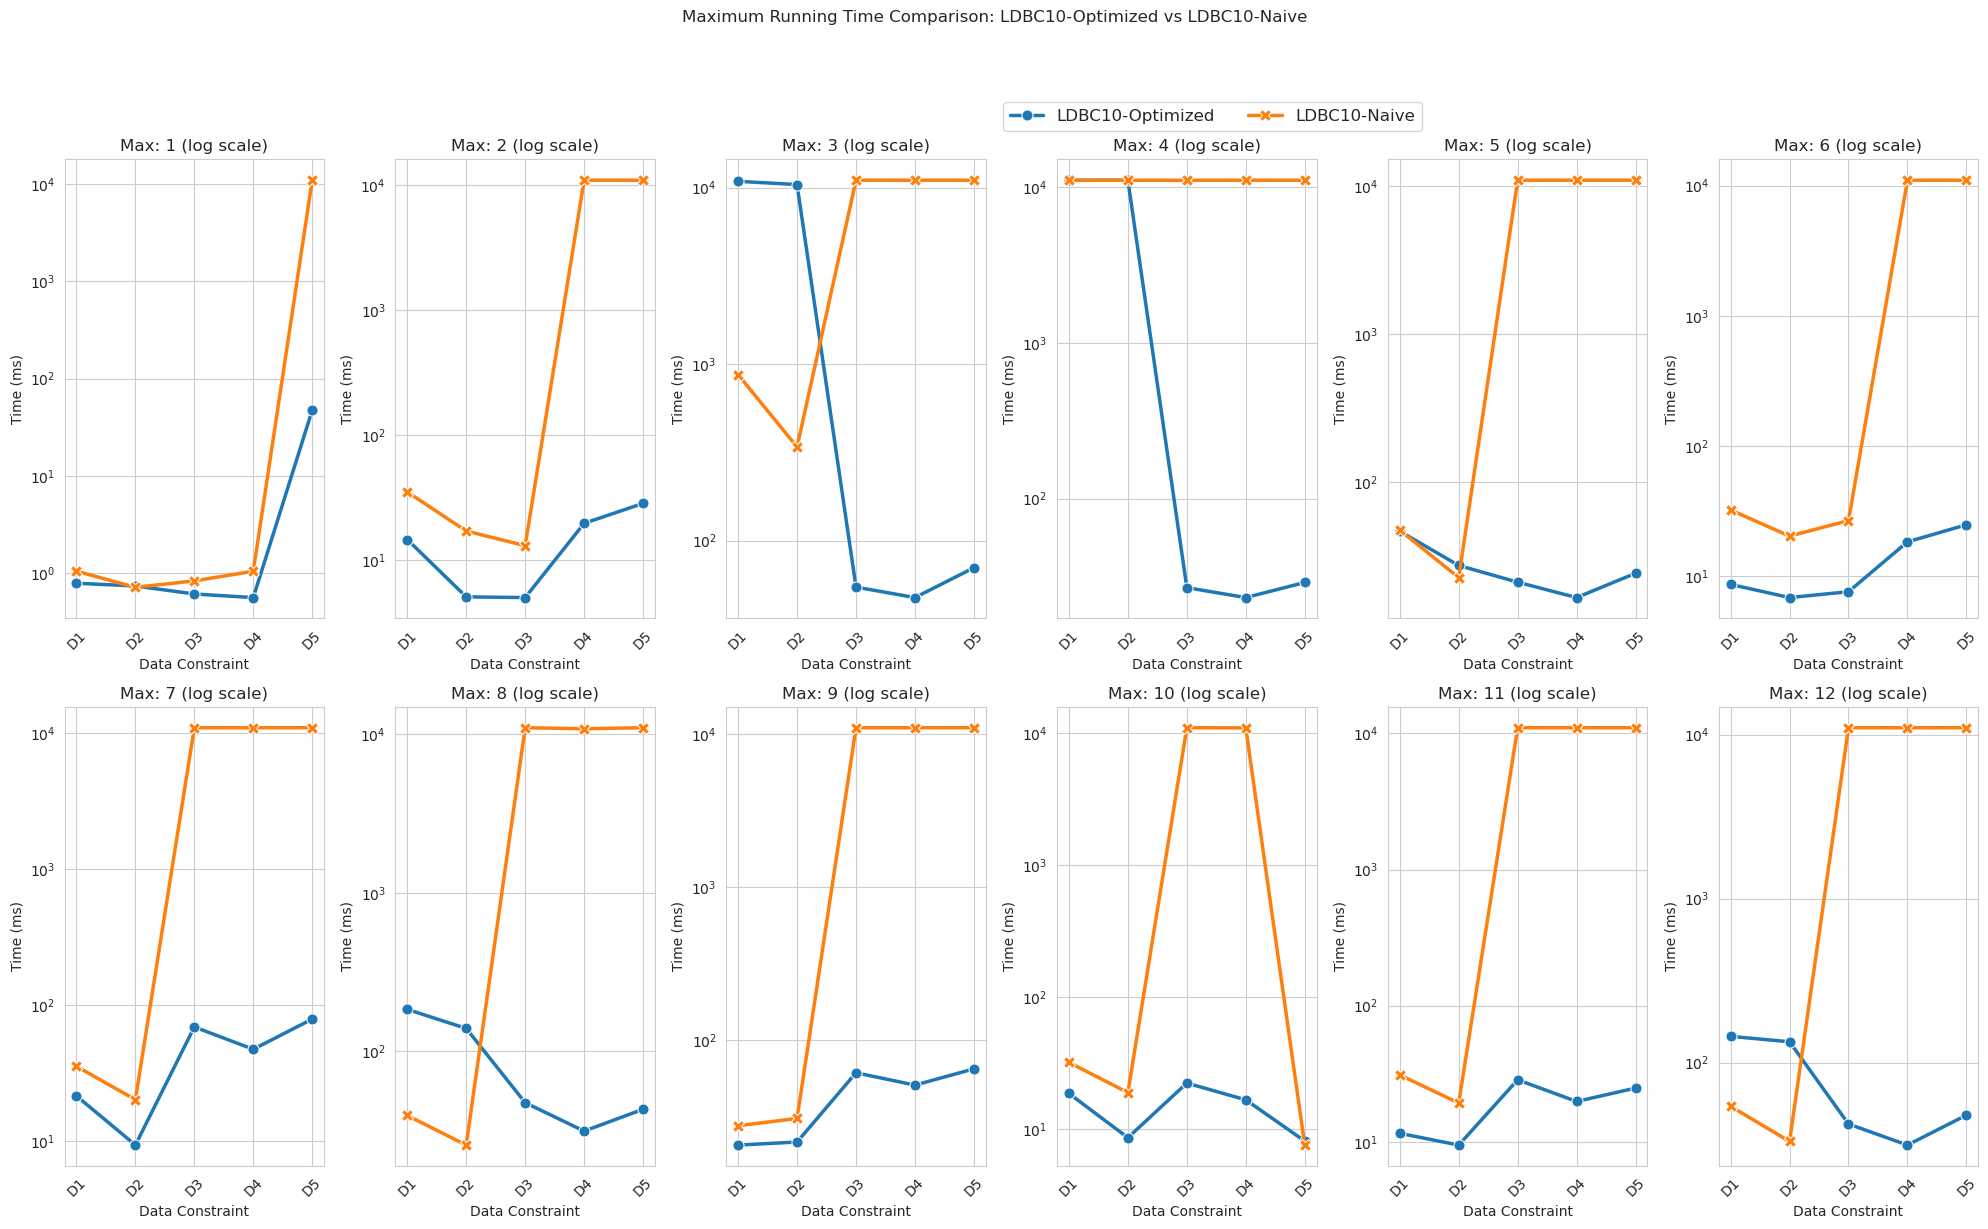

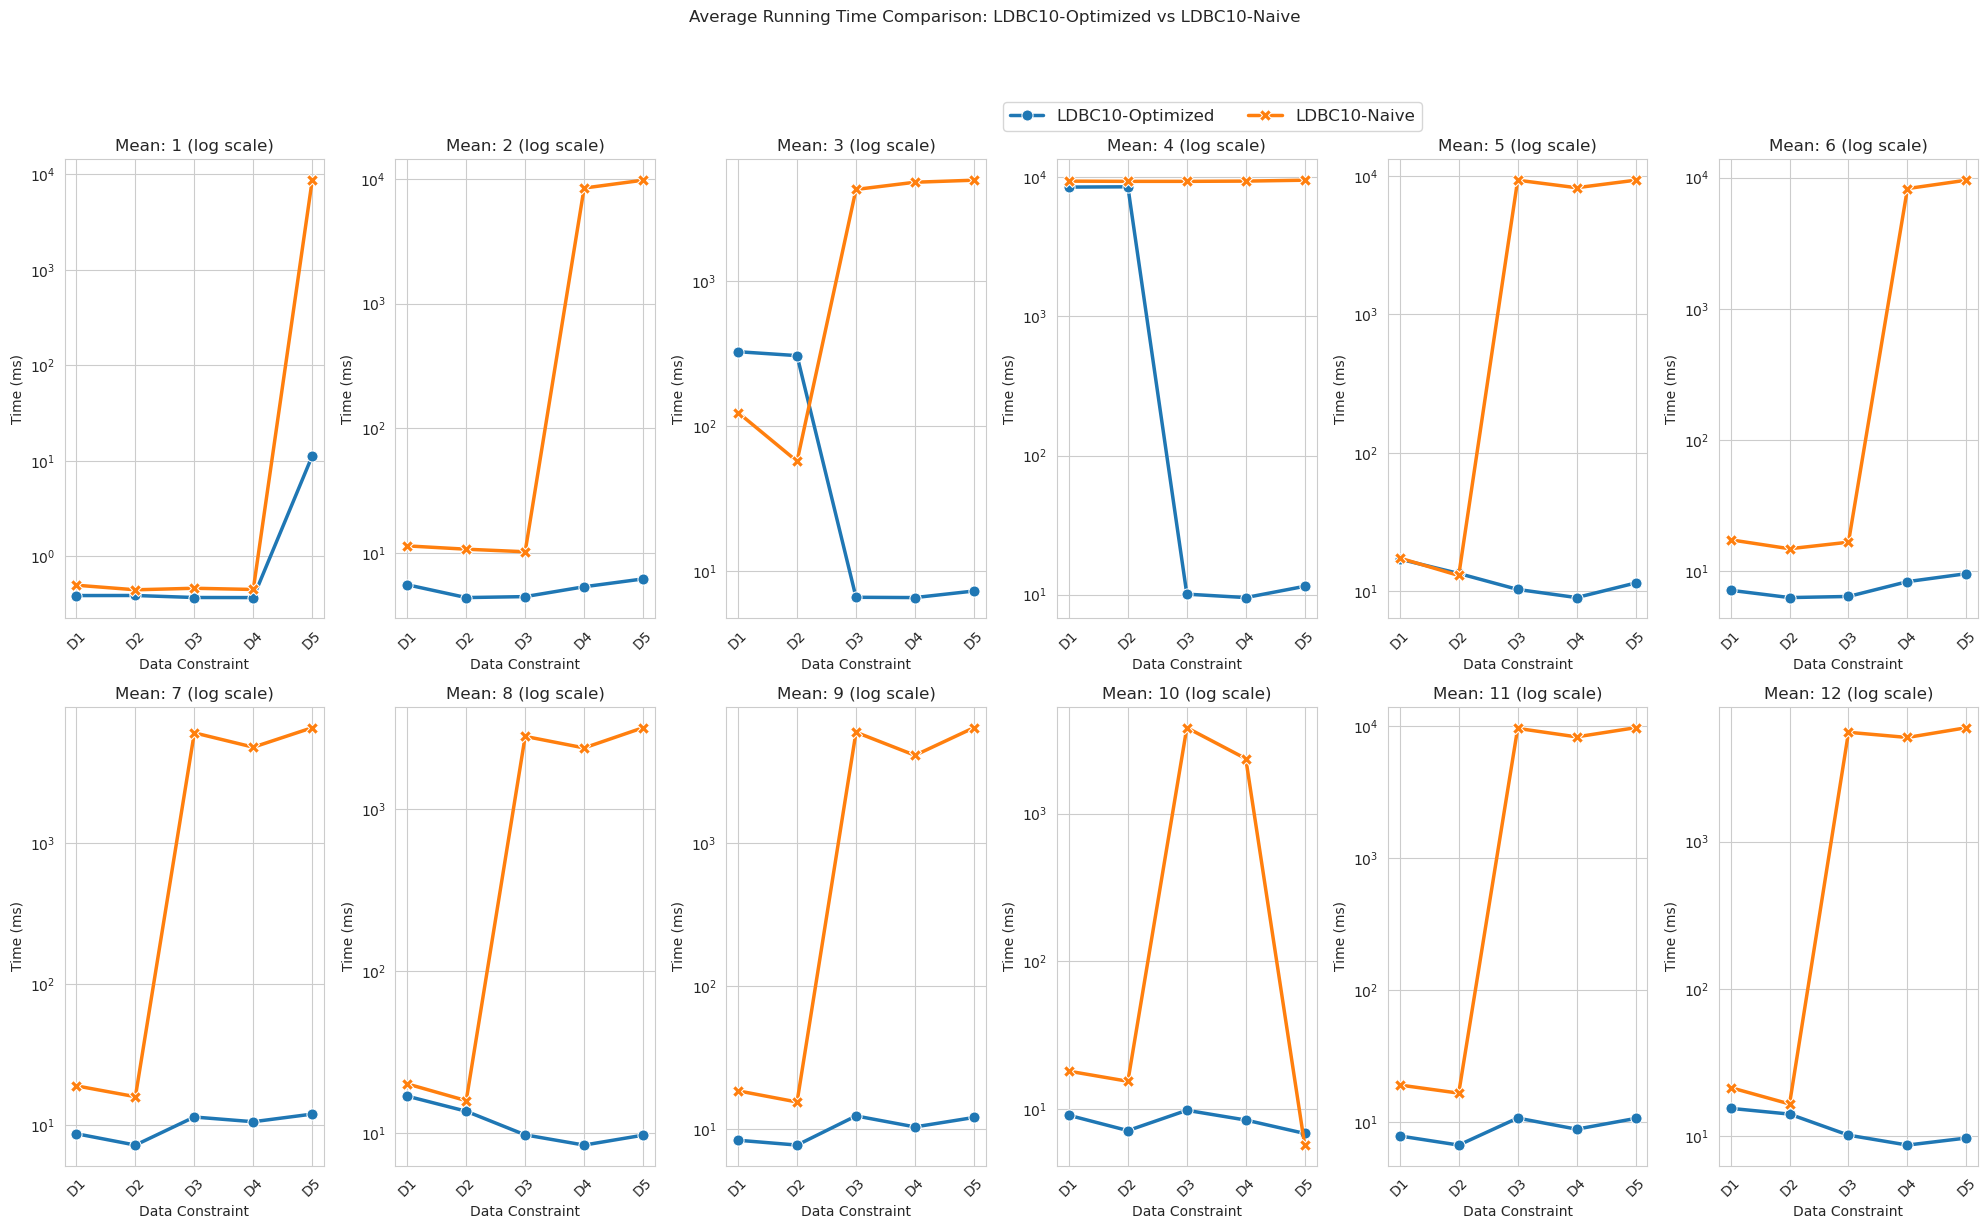

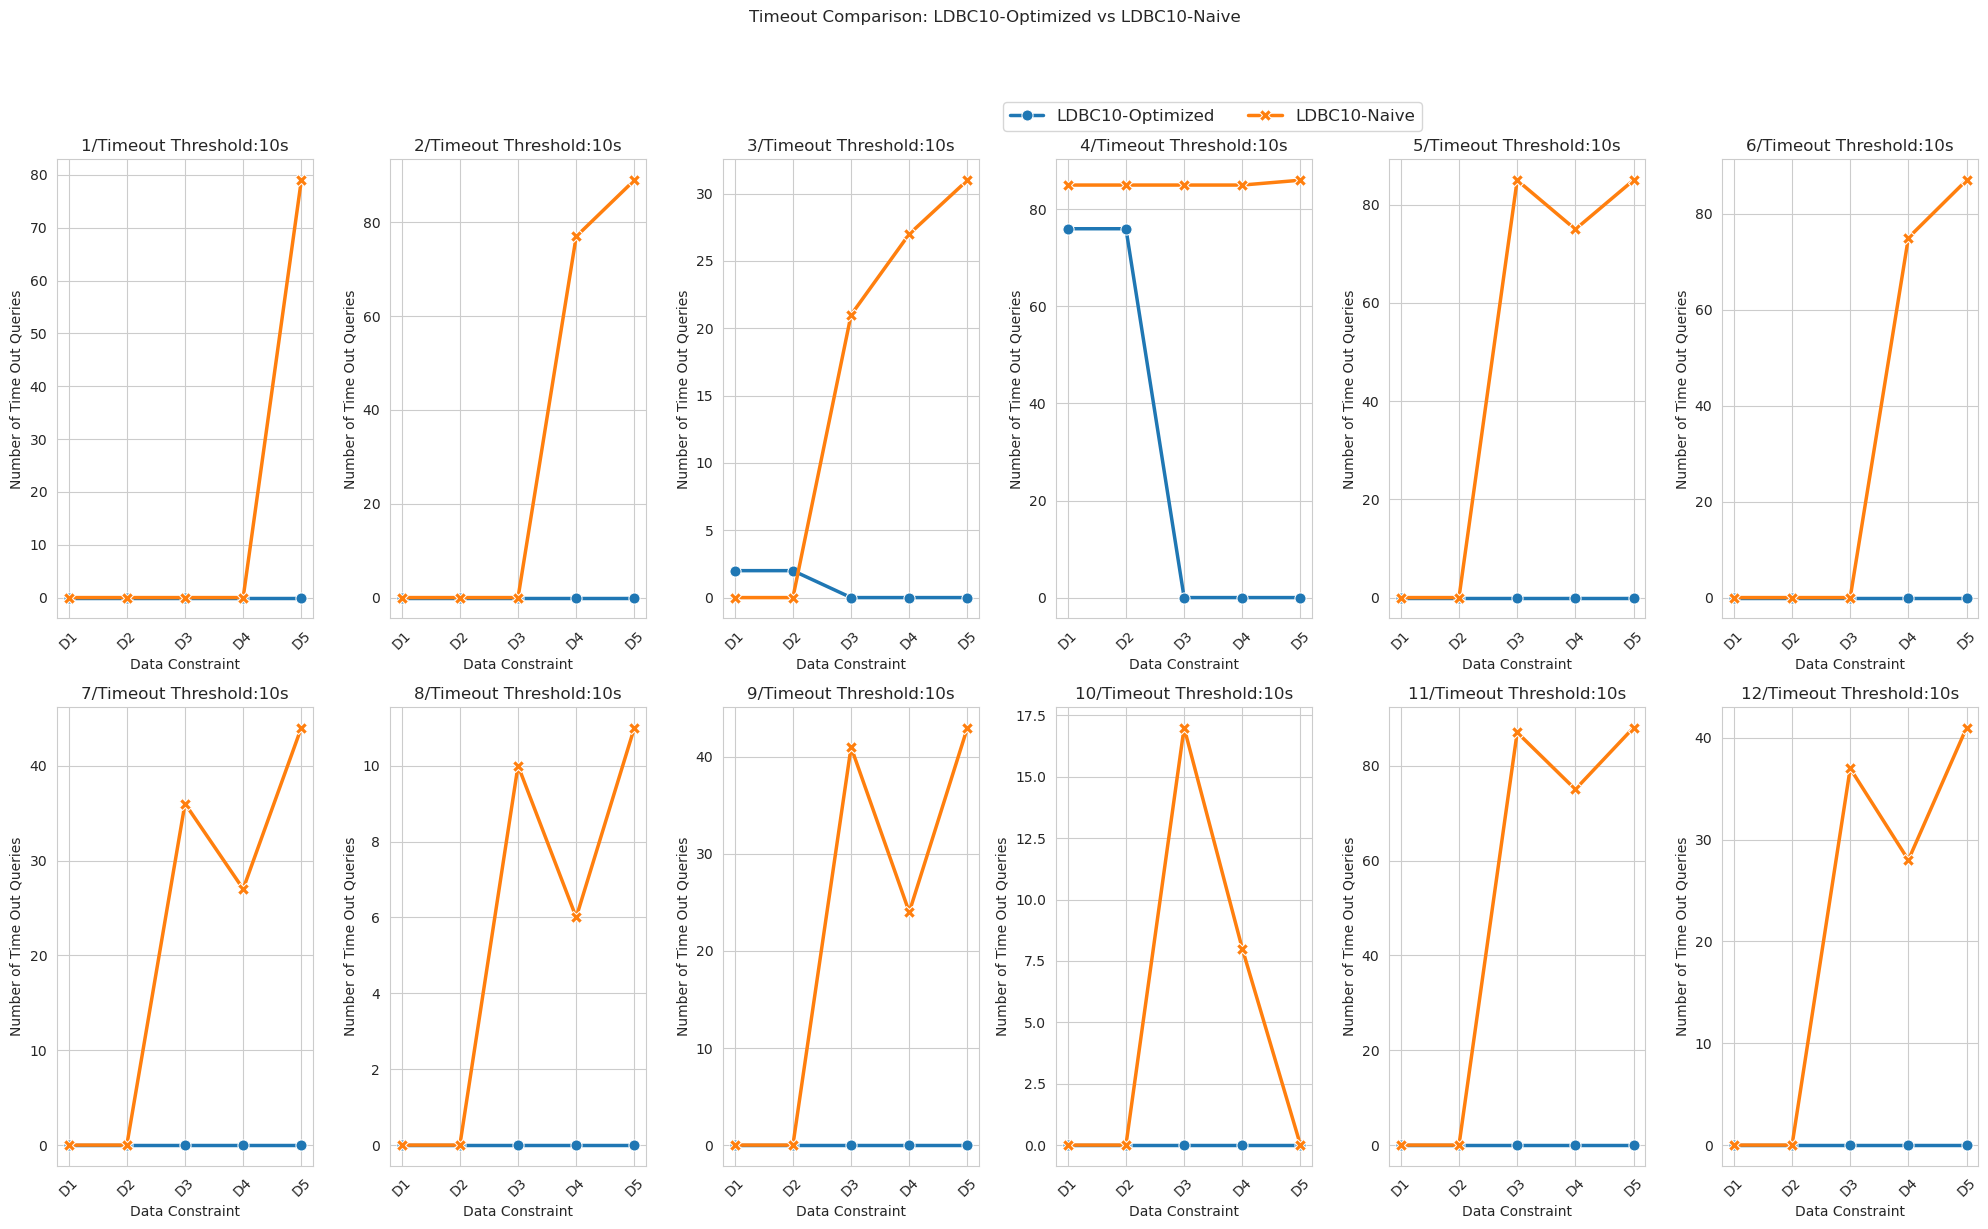

In [2]:
plot_compare("ldbc10/ldbc10_statistic.pkl", "ldbc10-naive/ldbc10_naive_statistic.pkl", "LDBC10", 10, True)

In [5]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker

def plot_boxplot_with_timeout(path, path2, ds, name1="Optimized", name2="Naive", timeout=10, log_scale=True):
    # Load both datasets
    with open(path, "rb+") as f:
        data1 = pickle.loads(f.read())
    with open(path2, "rb+") as f:
        data2 = pickle.loads(f.read())
    
    # Process both datasets
    data_groups = []
    for dataset, name in [(data1, name1), (data2, name2)]:
        for i in range(12):  # Q1-Q12
            id = 0
            for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
                if id == 0:
                    id += 1
                    continue
                data = list(map(lambda x: x, dataset[i*6 + id][2]))
                id += 1
                data_groups.append((f"Q{i+1}", dtype, name, data))

    # Prepare data for box plotting
    plot_data = []
    for group, dtype, dataset_name, values in data_groups:
        for value in values:
            plot_data.append({
                'Query': group,
                'Data Constraint': dtype,
                'Dataset': dataset_name,
                'Time': value,
                'IsTimeout': (value / 1000) > timeout
            })
    
    df = pd.DataFrame(plot_data)
    
    # Create subplots
    num_queries = 12
    cols = 6
    rows = (num_queries + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(24, 8*rows))
    axes = axes.flatten()  # Flatten for easier indexing
    sns.set_style("whitegrid")

    # Get current font sizes to calculate double size
    current_fontsize = plt.rcParams['font.size']
    double_fontsize = current_fontsize * 2

    for idx, query in enumerate(range(1, num_queries + 1), 1):
        ax = axes[idx-1]
        query_df = df[df['Query'] == f"Q{query}"]
        if query_df.empty:
            ax.set_title(f"No data for Q{query-1}", fontsize=double_fontsize)
            continue
        
        # Create box plots
        boxplot = sns.boxplot(data=query_df, x='Data Constraint', y='Time', 
                             hue='Dataset', ax=ax, showfliers=False,
                             palette=['skyblue', 'lightcoral'])
        
        # Add timeout threshold line
        timeout_ms = timeout * 1000  # Convert seconds to milliseconds
        ax.axhline(y=timeout_ms, color='red', linestyle='--', linewidth=3, 
                  alpha=0.8, label=f'Timeout Threshold ({timeout}s)')
        
        # Calculate and display timeout statistics with larger font
        for dataset_name in [name1, name2]:
            dataset_timeout_df = query_df[(query_df['Dataset'] == dataset_name) & (query_df['IsTimeout'])]
            timeout_count = len(dataset_timeout_df)
            total_count = len(query_df[query_df['Dataset'] == dataset_name])
            timeout_percentage = (timeout_count / total_count * 100) if total_count > 0 else 0
            
            # Add timeout count annotation with larger font
            color = 'blue' if dataset_name == name1 else 'red'
            ax.text(0.02, 0.85 - (0.1 * (list([name1, name2]).index(dataset_name))), 
                   f'{dataset_name}: {timeout_count}/{total_count} ({timeout_percentage:.1f}%)',
                   transform=ax.transAxes, verticalalignment='top',
                   color=color, fontweight='bold', fontsize=double_fontsize * 0.7)
        
        # Set titles and labels with larger font
        ax.set_title(f"Q{query-1}", fontweight='bold', fontsize=double_fontsize)
        ax.set_xlabel("", fontsize=double_fontsize)
        ax.set_ylabel("Time (ms)", fontsize=double_fontsize)
        
        # Increase tick label size
        ax.tick_params(axis='x', labelsize=double_fontsize * 0.8)
        ax.tick_params(axis='y', labelsize=double_fontsize * 0.8)
        
        plt.setp(ax.get_xticklabels(), rotation=45)
        
        # Check for log scale
        max_time_val = query_df['Time'].max()
        min_time_val = query_df[query_df['Time'] > 0]['Time'].min()  # Exclude zeros
        if log_scale and max_time_val > 0 and min_time_val > 0 and max_time_val / min_time_val > 100:
            ax.set_yscale("log")
            ax.set_title(f"Q{query-1} (log scale)", fontweight='bold', fontsize=double_fontsize)
        else:
            # Reduce distance between y-axis ticks by half for linear scale
            y_min, y_max = ax.get_ylim()
            current_ticks = ax.get_yticks()
            
            if len(current_ticks) > 1:
                current_spacing = current_ticks[1] - current_ticks[0]
                new_spacing = current_spacing / 2
                
                # Make sure we don't create too many ticks
                max_ticks = 20
                num_ticks = int((y_max - y_min) / new_spacing) + 1
                
                if num_ticks <= max_ticks:
                    new_ticks = np.arange(round(y_min / new_spacing) * new_spacing, 
                                         round(y_max / new_spacing) * new_spacing + new_spacing, 
                                         new_spacing)
                    ax.set_yticks(new_ticks)
                else:
                    # Use automatic locator if too many ticks would be created
                    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=max_ticks))

        # Remove individual legends (we'll create a global one)
        if ax.get_legend():
            ax.get_legend().remove()
    
    # Remove empty subplots if any
    for idx in range(num_queries, len(axes)):
        fig.delaxes(axes[idx])
    
    # Create comprehensive legend with much larger text
    legend_elements = [
        Patch(facecolor='skyblue', label=f'{name1}'),
        Patch(facecolor='lightcoral', label=f'{name2}'),
        Line2D([0], [0], color='red', linestyle='--', linewidth=3, 
               label=f'Timeout Threshold ({timeout}s)')
    ]
    
    fig.legend(handles=legend_elements, loc='upper center', 
               bbox_to_anchor=(0.5, 1.0), ncol=3, 
               fontsize=double_fontsize * 1.2,  # Even larger for legend
               frameon=True, fancybox=True, shadow=True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.savefig(f'figure/{ds}-{name1}-vs-{name2}-boxplot-timeout.pdf', 
                format='pdf', dpi=1200, bbox_inches='tight')
    plt.show()

# Optional: Keep the original function for comparison
def plot_combined_comparison(path, path2, name1, name2, timeout, log_scale=True):
    # Original implementation here
    pass

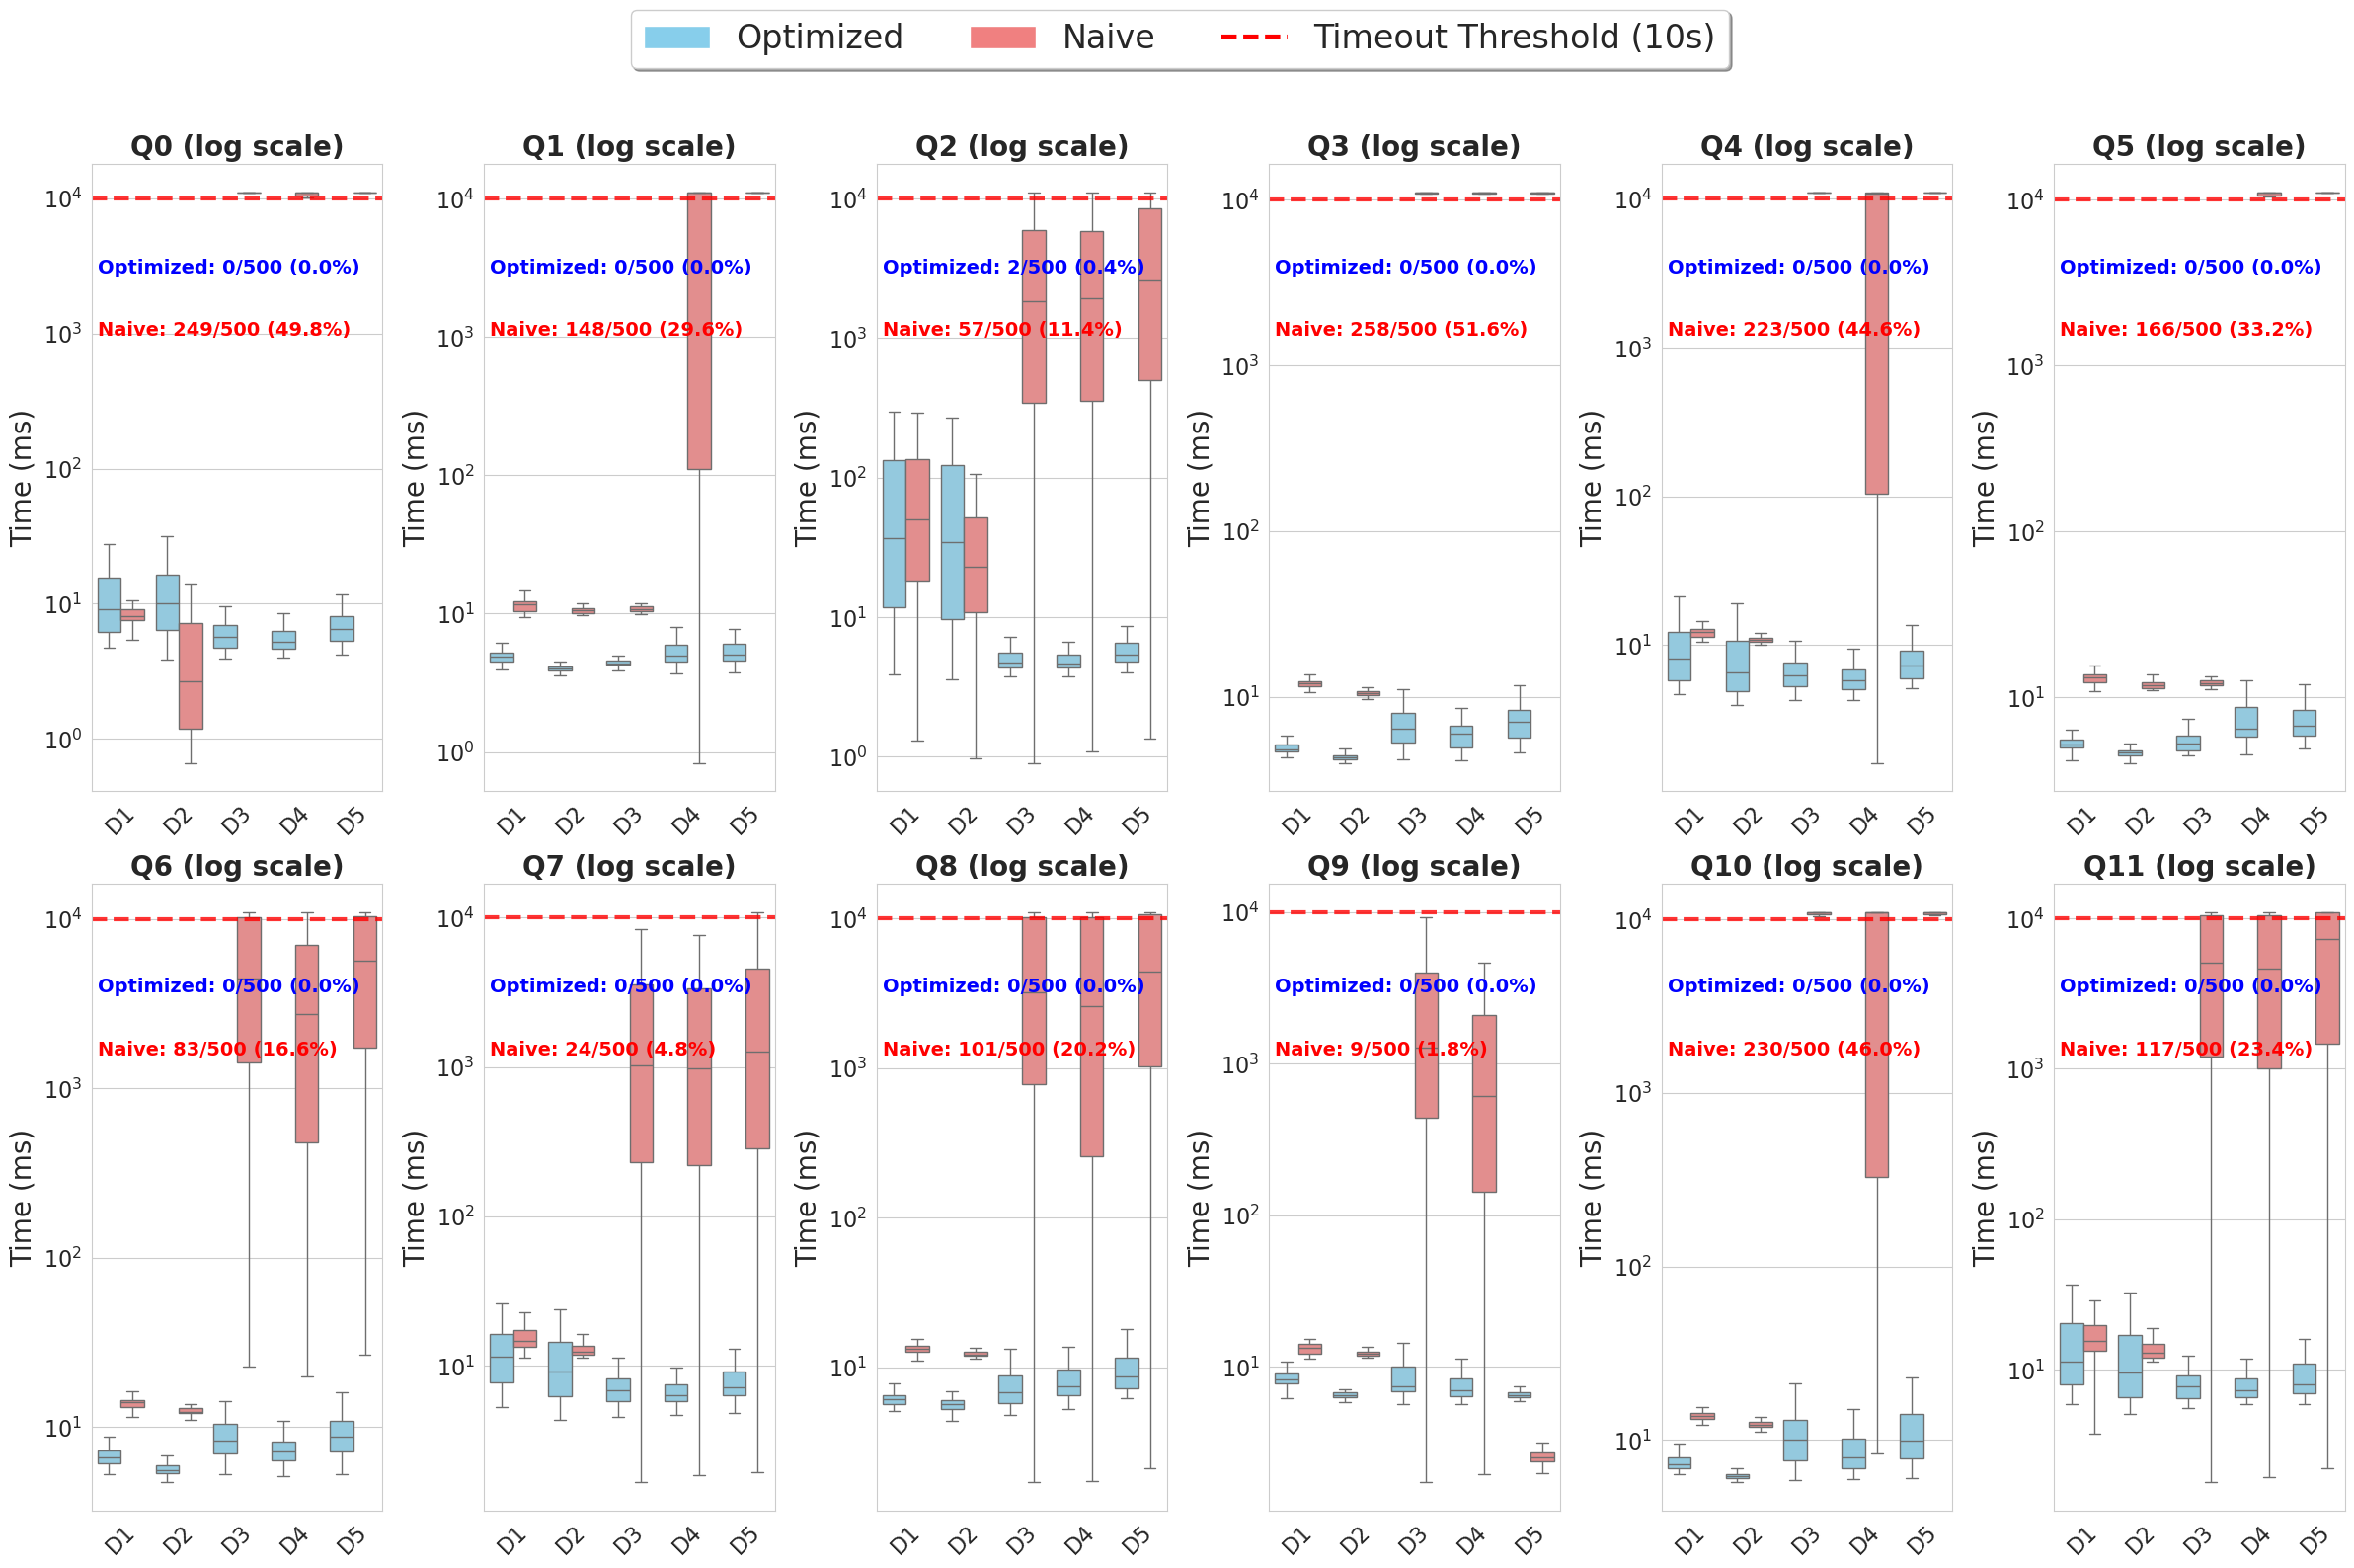

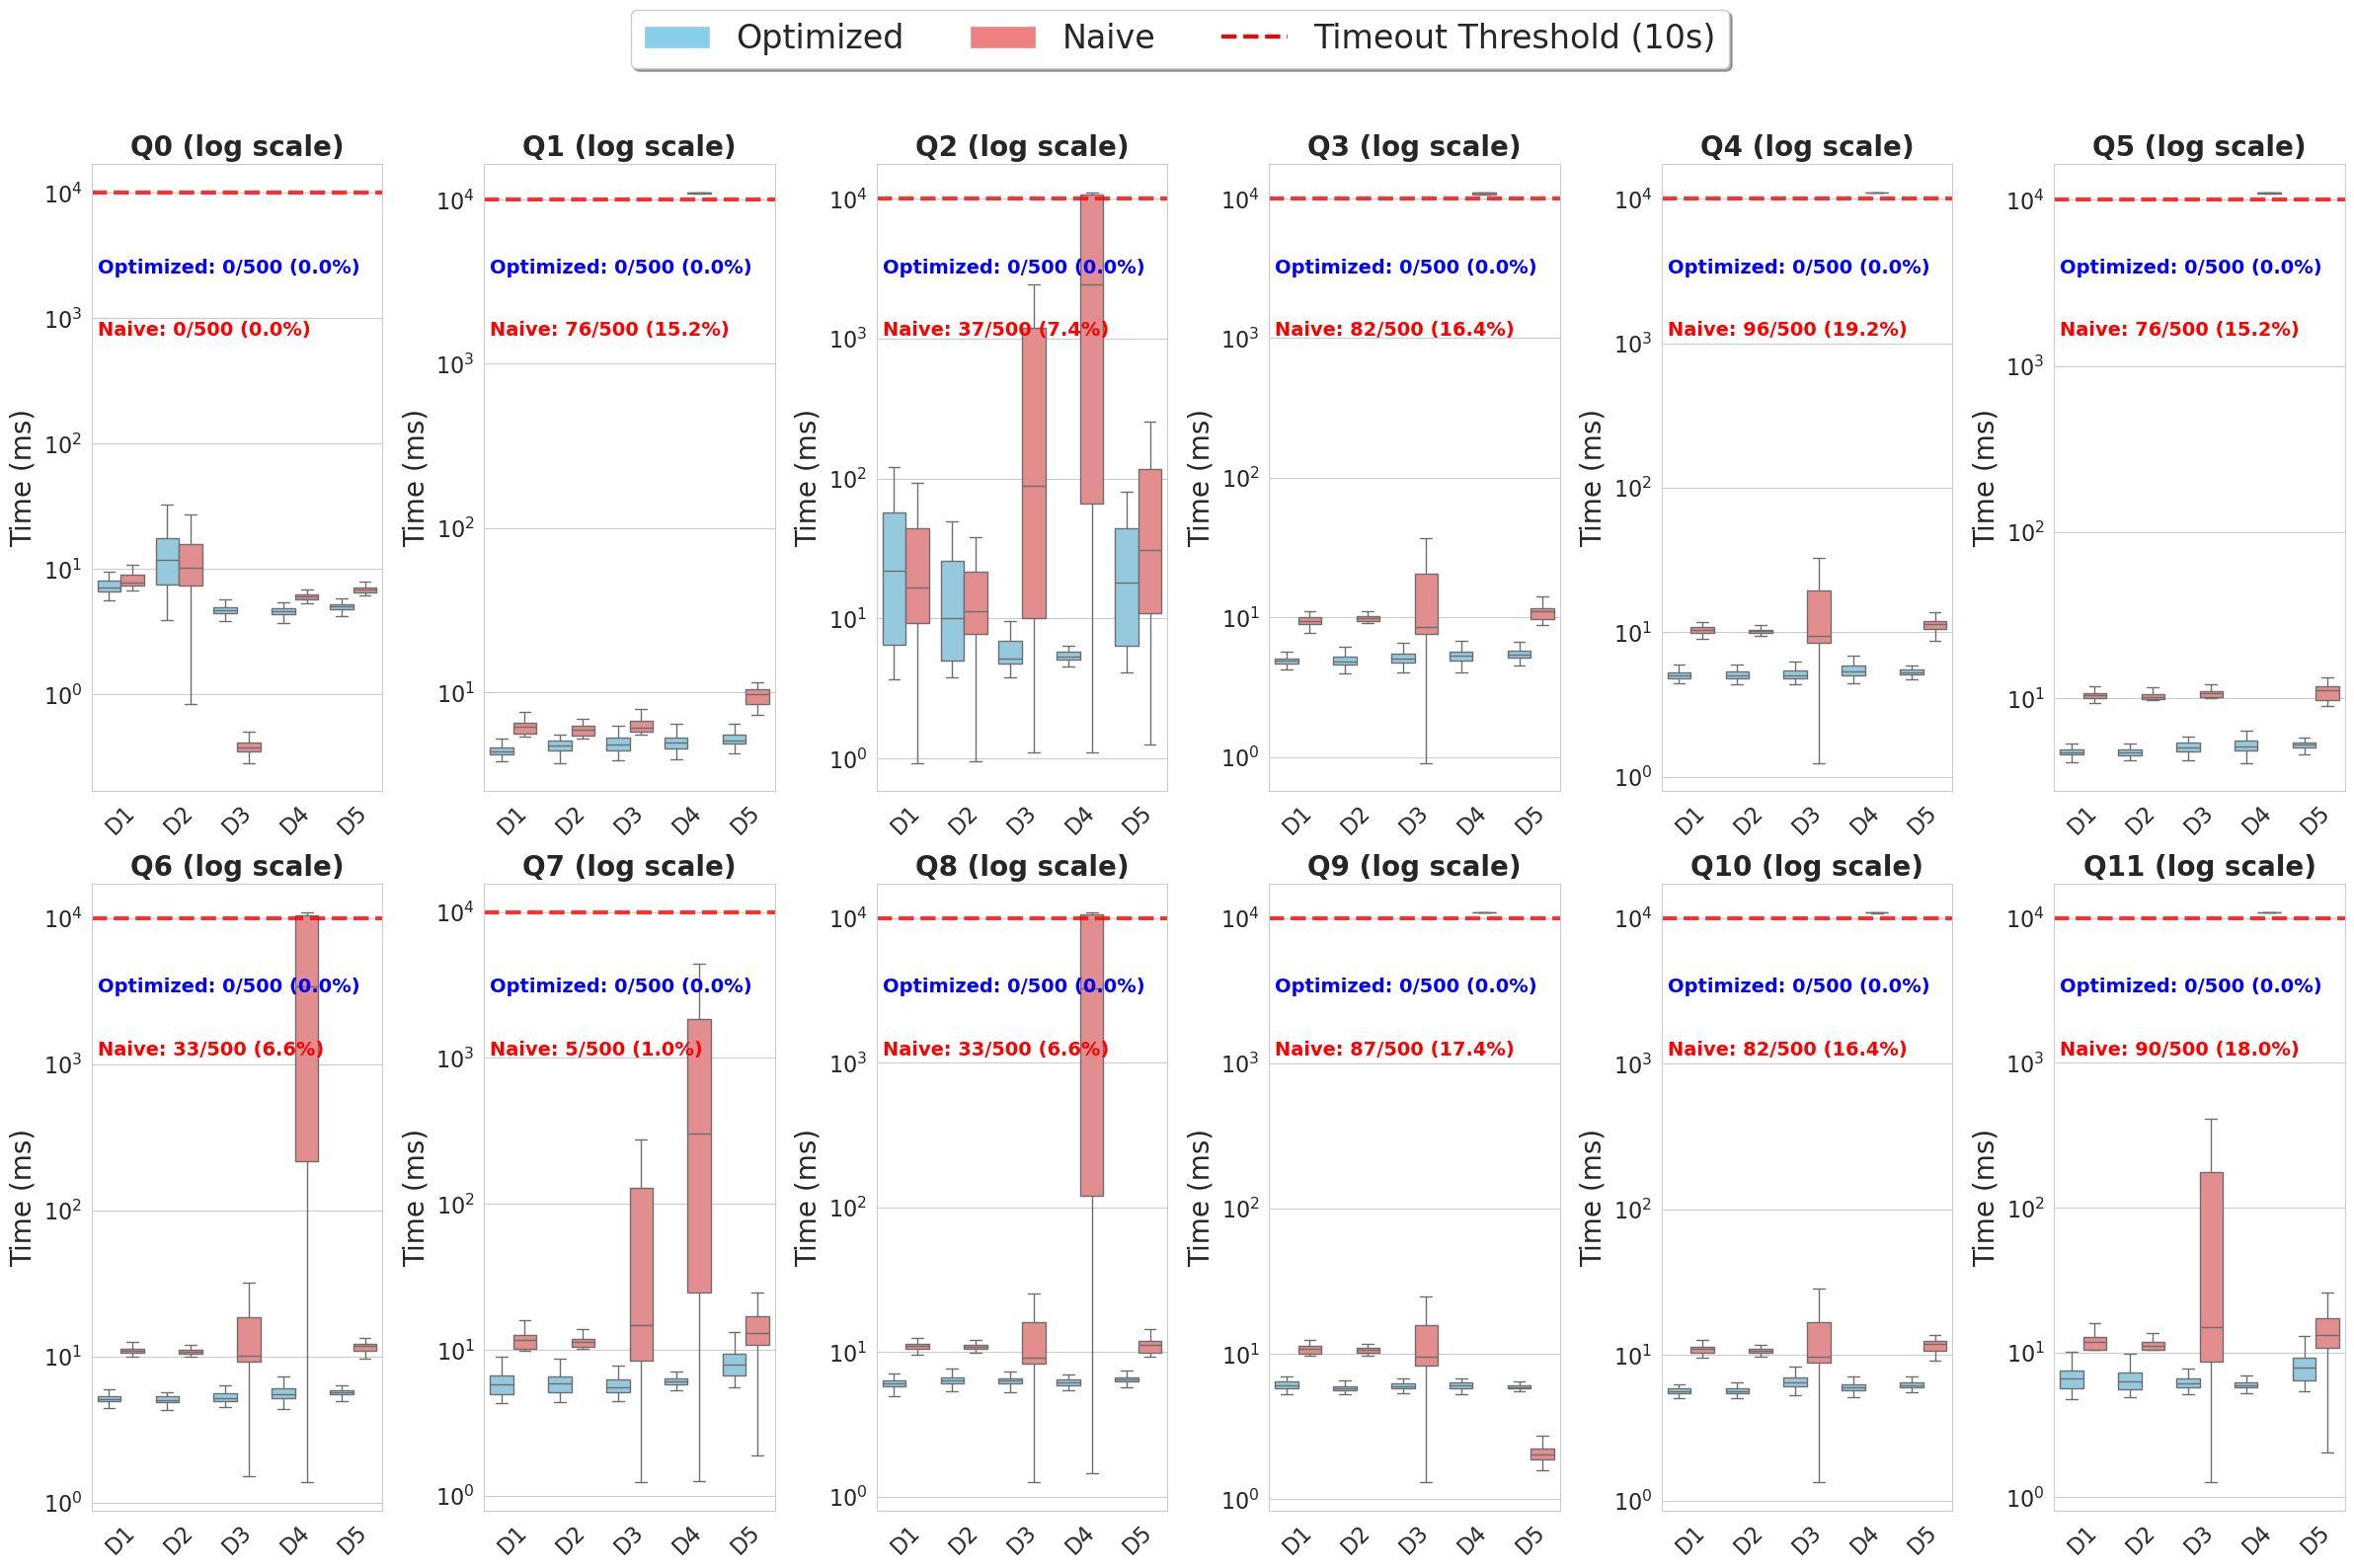

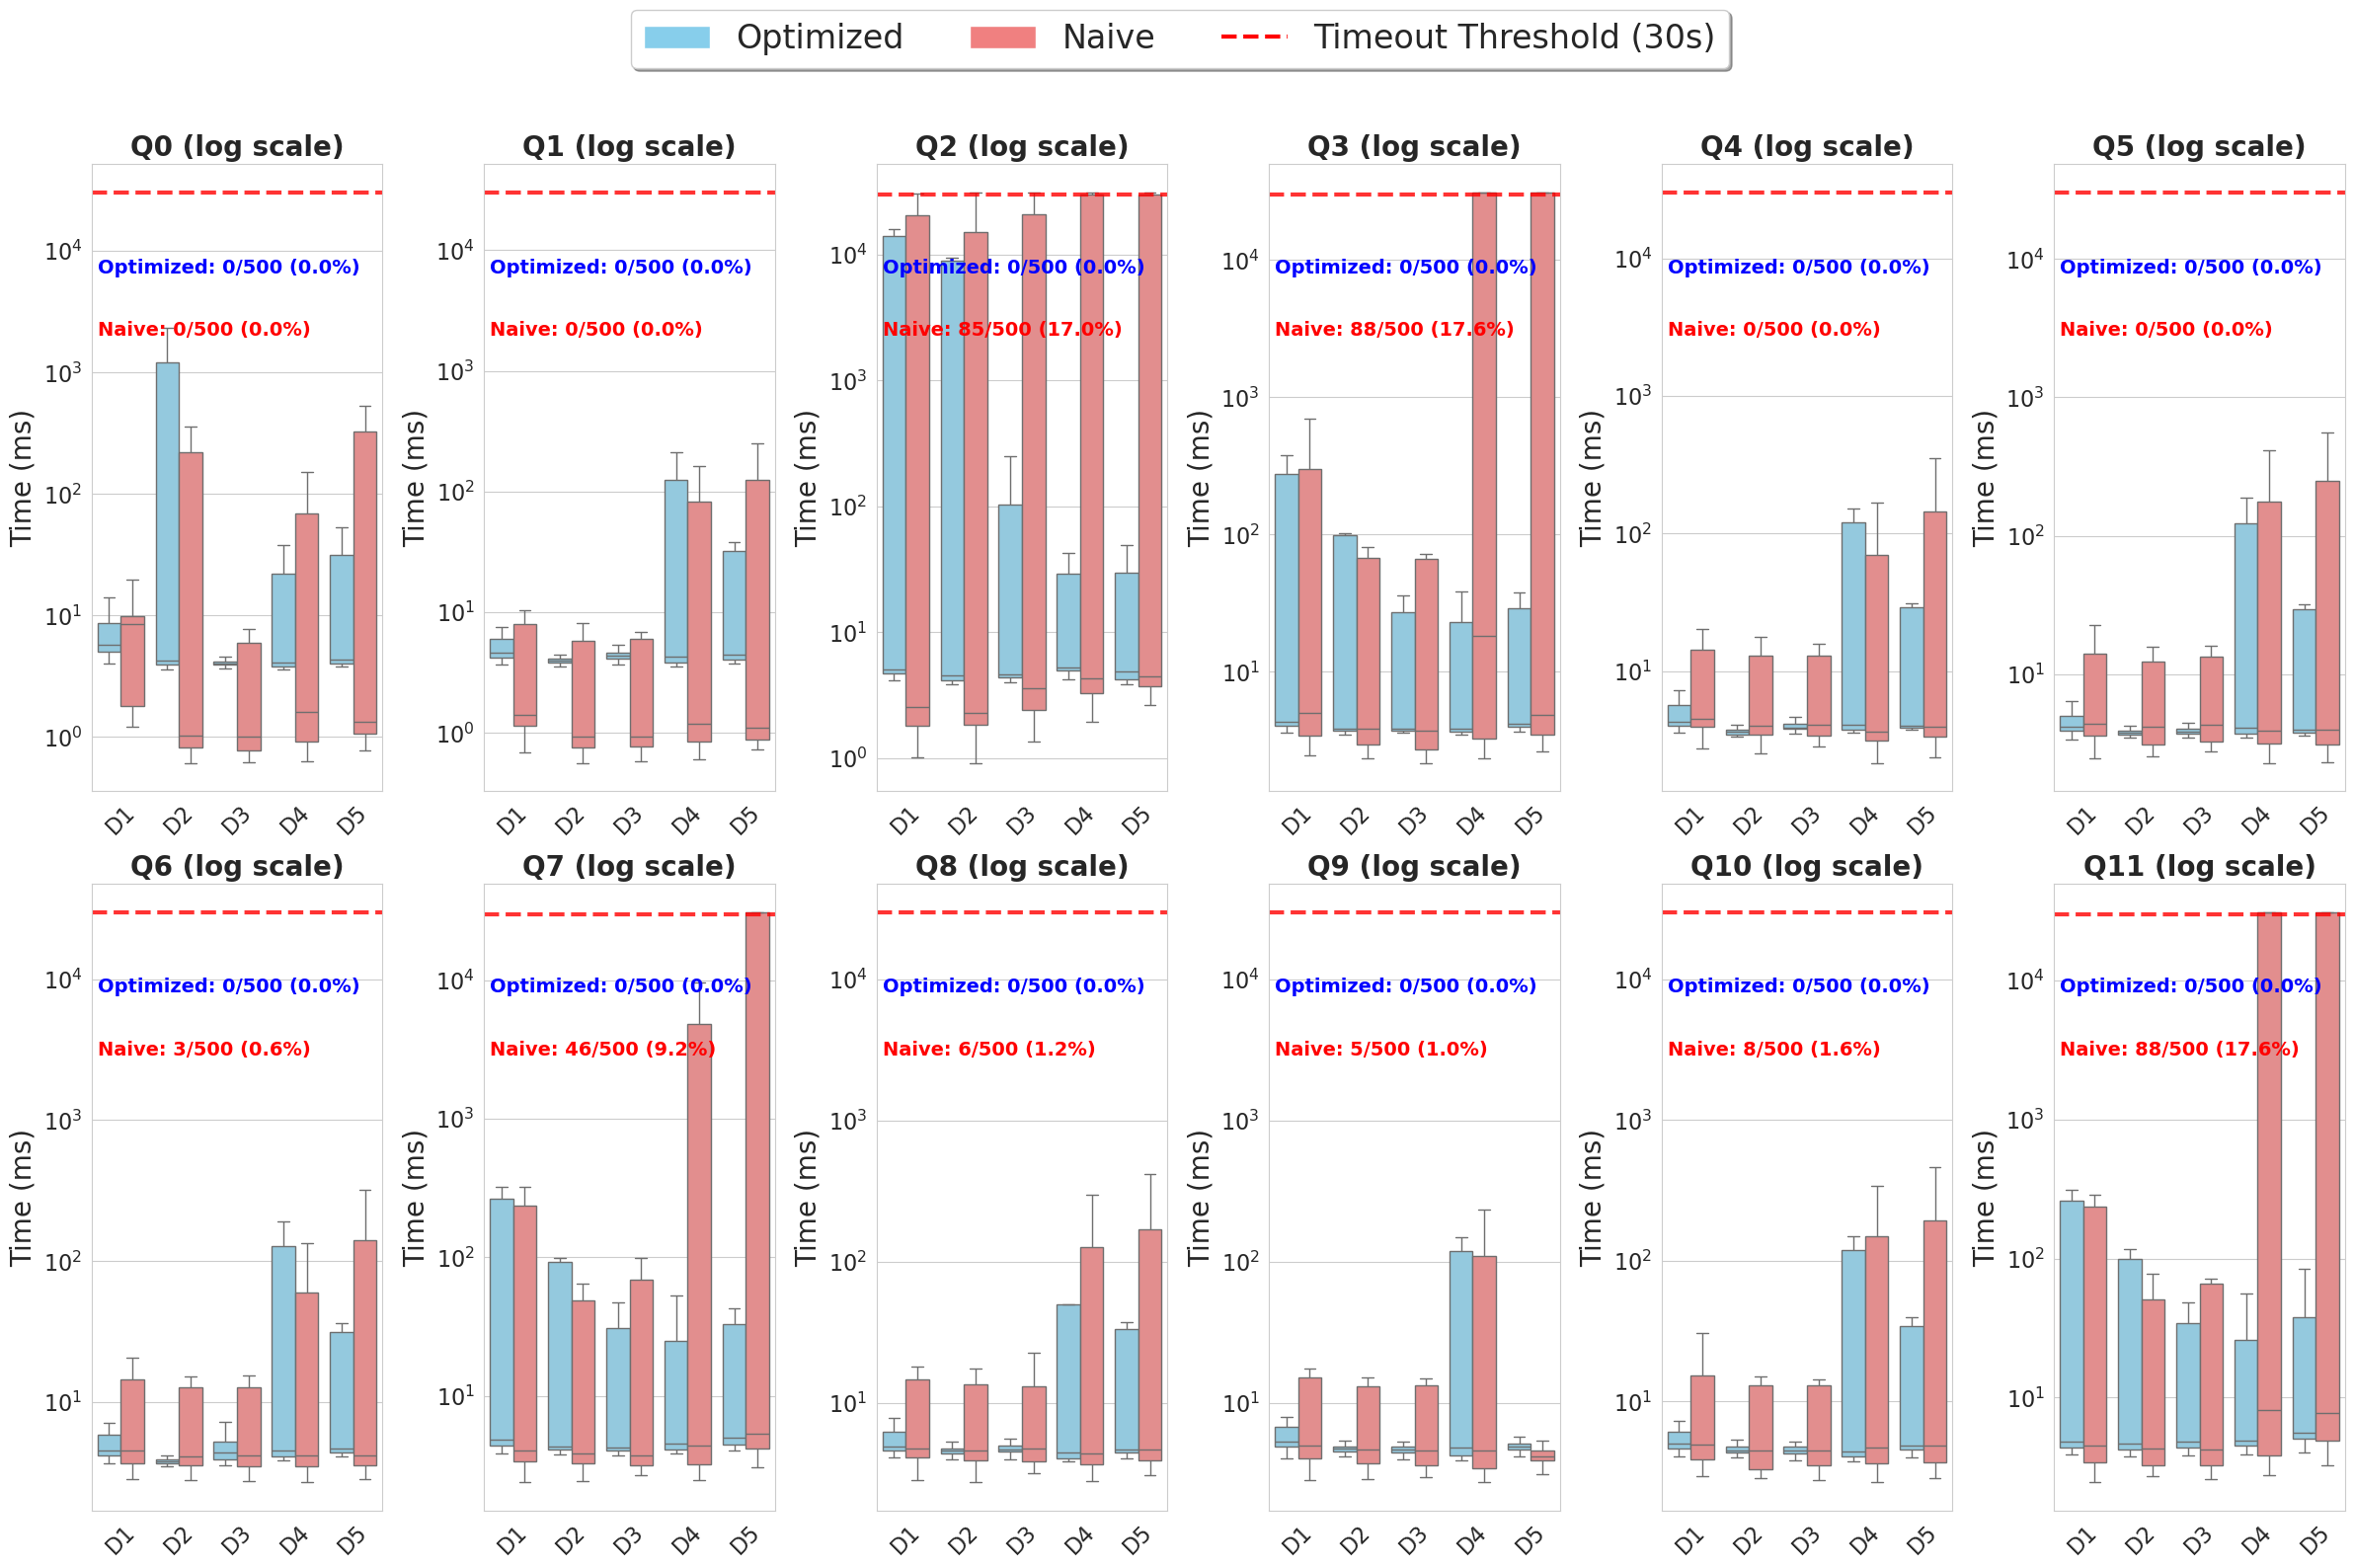

In [6]:
plot_boxplot_with_timeout("ldbc10/ldbc10_statistic.pkl", "ldbc10-naive/ldbc10_naive_statistic.pkl", ds="LDBC10", timeout=10)
plot_boxplot_with_timeout("pokec/pokec_statistic.pkl", "pokec-naive/pokec_naive_statistic.pkl", ds="Pokec", timeout=10)
plot_boxplot_with_timeout("telecom/telecom_statistic.pkl", "telecom-naive/telecom_naive_statistic.pkl", ds="Telecom", timeout=30)

In [78]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch
import matplotlib.ticker as ticker

def plot_single_dataset_boxplot(path, ds, name="Dataset", log_scale=True):
    # Load the dataset
    with open(path, "rb+") as f:
        data = pickle.loads(f.read())
    
    # Process the dataset
    data_groups = []
    for i in range(12):  # Q1-Q12
        id = 0
        for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
            if id == 0:
                id += 1
                continue
            values = list(map(lambda x: x, data[i*6 + id][2]))
            data_groups.append((f"Q{i+1}", dtype, name, values))
            id += 1

    # Prepare data for box plotting
    plot_data = []
    for group, dtype, dataset_name, values in data_groups:
        for value in values:
            plot_data.append({
                'Query': group,
                'Data Constraint': dtype,
                'Dataset': dataset_name,
                'Time': value
            })
    
    df = pd.DataFrame(plot_data)
    
    # Create a single large figure
    fig, ax = plt.subplots(figsize=(16, 10))
    sns.set_style("whitegrid")

    # Get current font sizes to calculate double size
    current_fontsize = plt.rcParams['font.size']
    double_fontsize = current_fontsize * 3

    # Create box plots for all queries (Q as x-axis)
    boxplot = sns.boxplot(data=df, x='Query', y='Time', 
                         hue='Data Constraint', ax=ax, showfliers=False,
                         palette='viridis', dodge=True)
    
    # Set titles and labels with larger font
    # ax.set_title(f"Runtime Distribution - {ds}", fontweight='bold', fontsize=double_fontsize * 1.2)
    ax.set_xlabel("")
    ax.set_ylabel("Time (ms)", fontsize=double_fontsize)
    
    # Increase tick label size
    ax.tick_params(axis='x', labelsize=double_fontsize * 0.9)
    ax.tick_params(axis='y', labelsize=double_fontsize * 0.9)
    
    # plt.setp(ax.get_xticklabels())
    
    # Check for log scale
    max_time_val = df['Time'].max()
    min_time_val = df[df['Time'] > 0]['Time'].min()  # Exclude zeros
    if log_scale and max_time_val > 0 and min_time_val > 0 and max_time_val / min_time_val > 1000:
        ax.set_yscale("log")
        # ax.set_title(f"Runtime Distribution - {ds} (log scale)", fontweight='bold', fontsize=double_fontsize * 1.2)
    else:
        # Reduce distance between y-axis ticks by half for linear scale
        y_min, y_max = ax.get_ylim()
        current_ticks = ax.get_yticks()
        
        if len(current_ticks) > 1:
            current_spacing = current_ticks[1] - current_ticks[0]
            new_spacing = current_spacing / 2
            
            # Make sure we don't create too many ticks
            max_ticks = 20
            num_ticks = int((y_max - y_min) / new_spacing) + 1
            
            if num_ticks <= max_ticks:
                new_ticks = np.arange(round(y_min / new_spacing) * new_spacing, 
                                     round(y_max / new_spacing) * new_spacing + new_spacing, 
                                     new_spacing)
                ax.set_yticks(new_ticks)
            else:
                # Use automatic locator if too many ticks would be created
                ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=max_ticks))

    # Create legend for data constraints only
    data_constraints = ["D1", "D2", "D3", "D4", "D5"]
    colors = plt.cm.viridis(np.linspace(0, 1, len(data_constraints)))
    
    legend_elements = []
    for constraint, color in zip(data_constraints, colors):
        legend_elements.append(
            Patch(facecolor=color, label=f'{constraint}')
        )
    

    legend = ax.legend(handles=legend_elements, 
                      loc='upper center',  # Changed to upper right corner
                      bbox_to_anchor=(0.5, 1.2),  # Slightly inside the corner
                      ncol=5,  # Single column for corner placement
                      fontsize=double_fontsize ,  # Even larger text for legend
                      frameon=True, 
                      fancybox=True, 
                      shadow=True,
                      title="Data Constraints", 
                      title_fontsize=double_fontsize  )  # Larger title
    plt.tight_layout(rect=[0, 0, 1, 0.90])
    plt.savefig(f'figure/{ds}-query-x-axis-boxplot.pdf', 
                format='pdf', dpi=1200, bbox_inches='tight')
    plt.show()


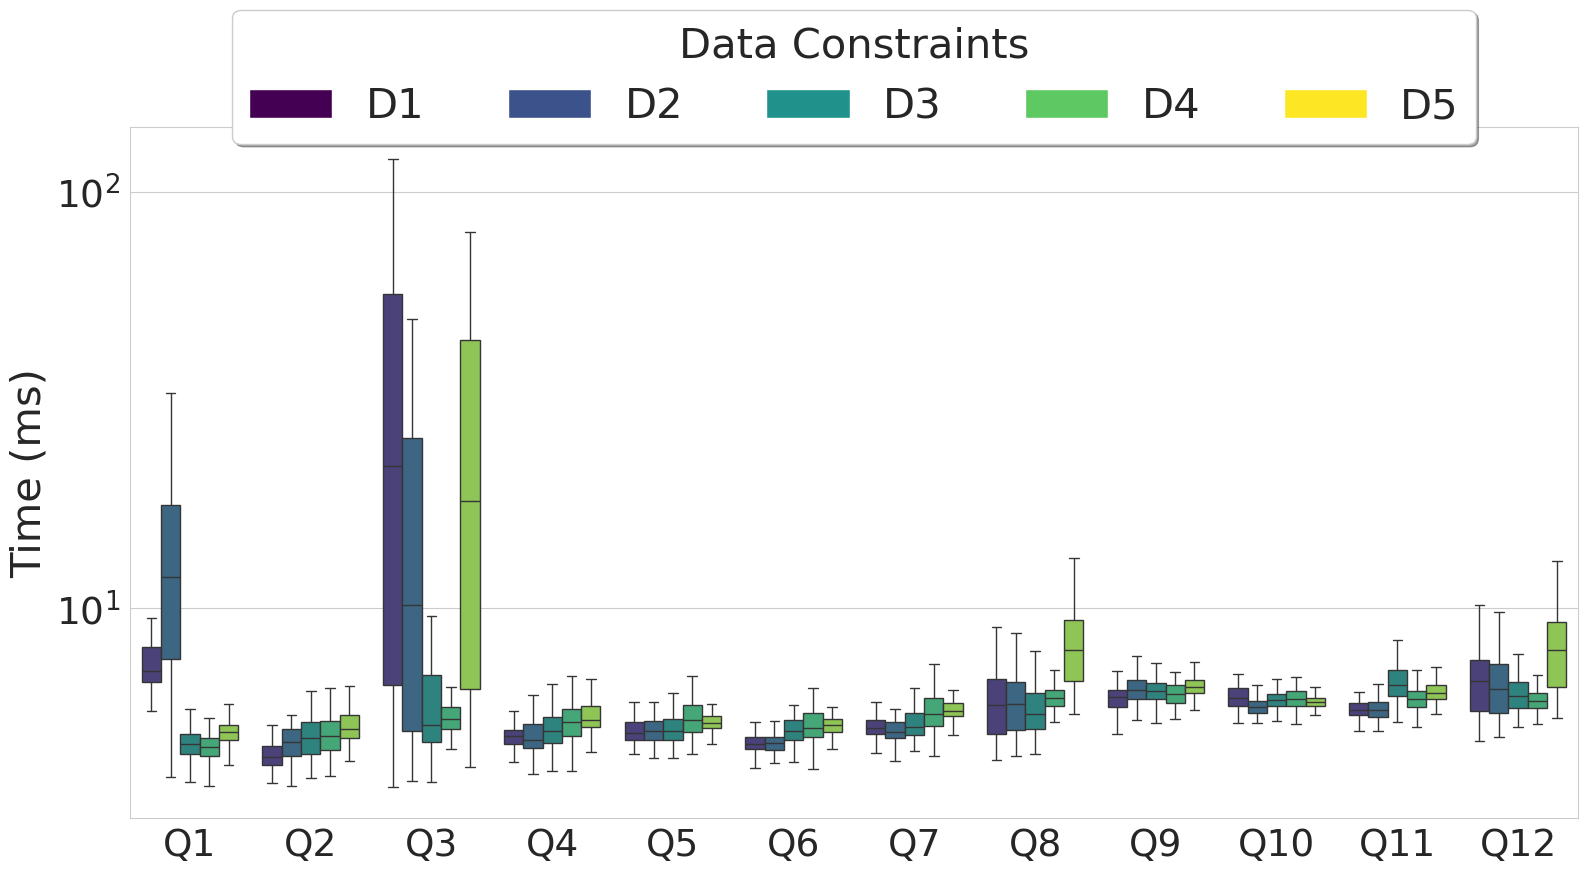

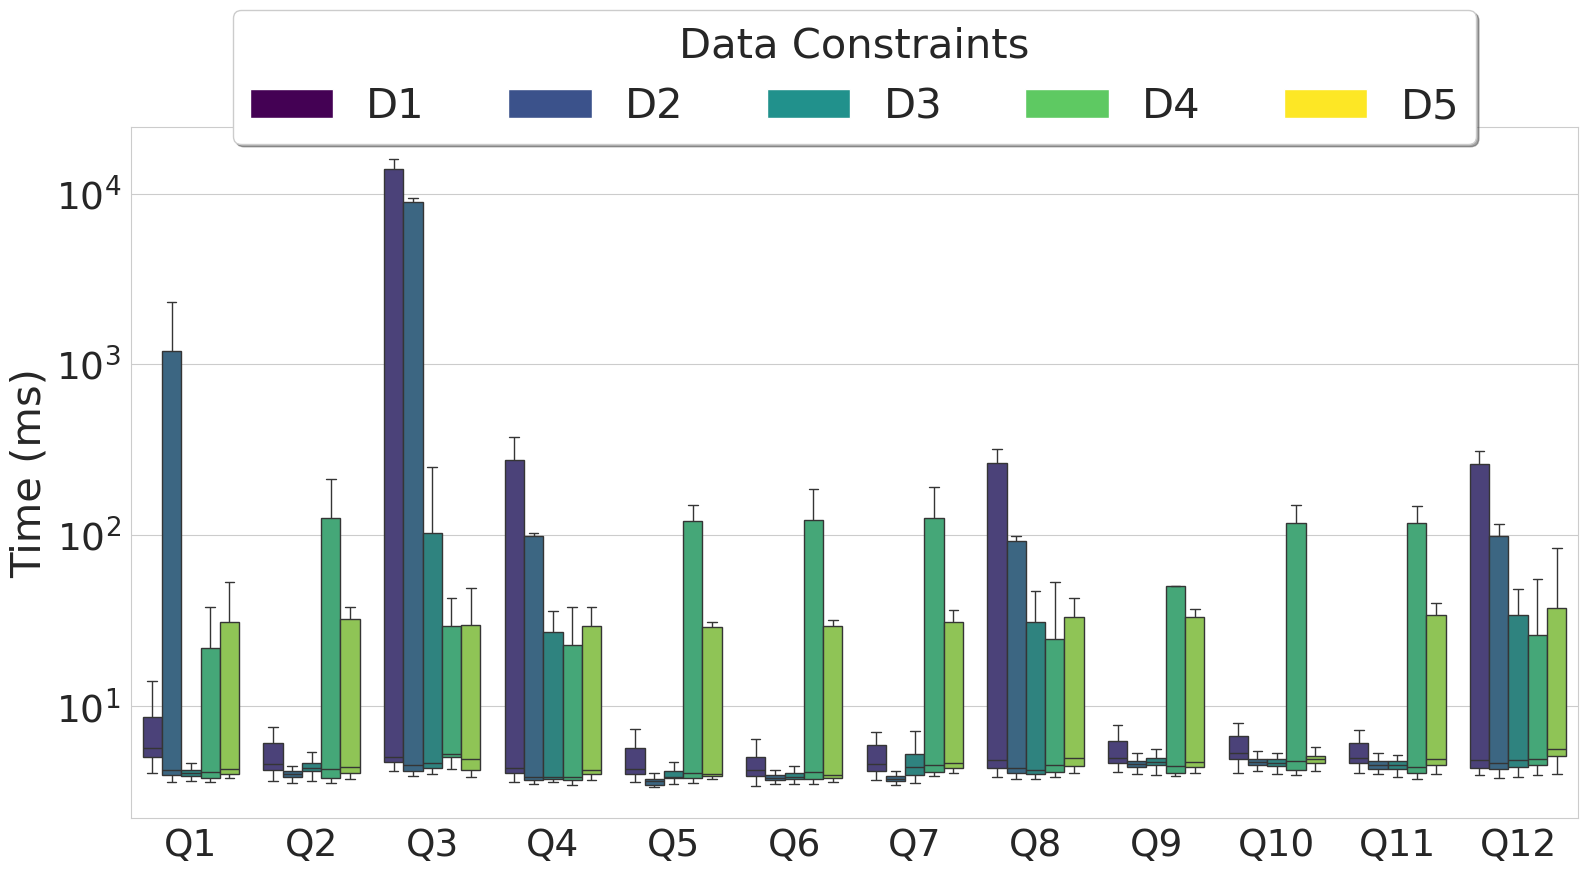

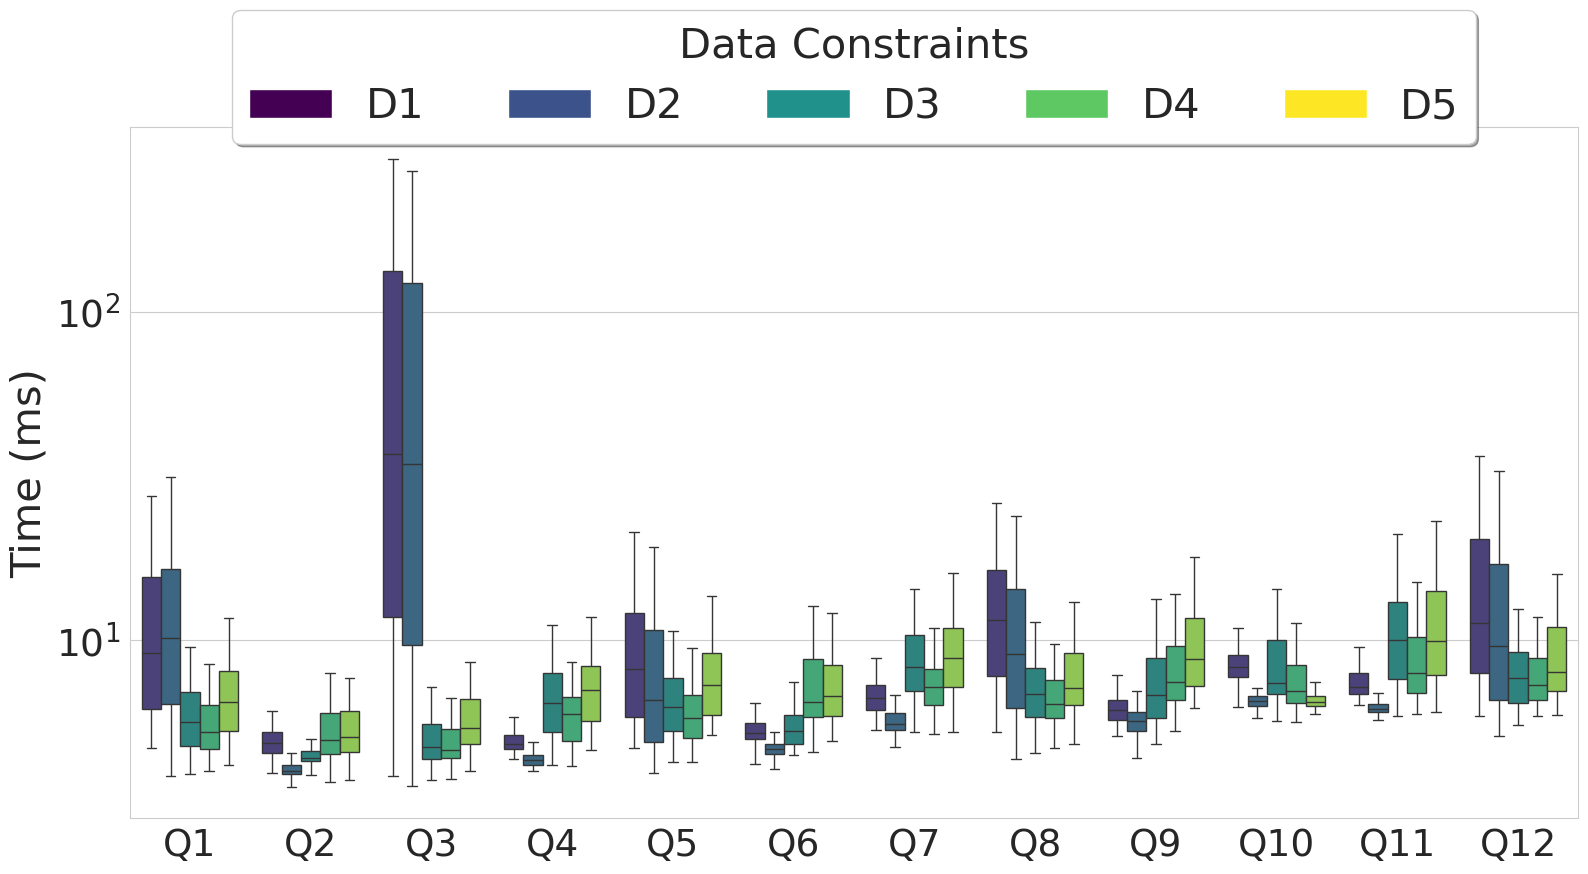

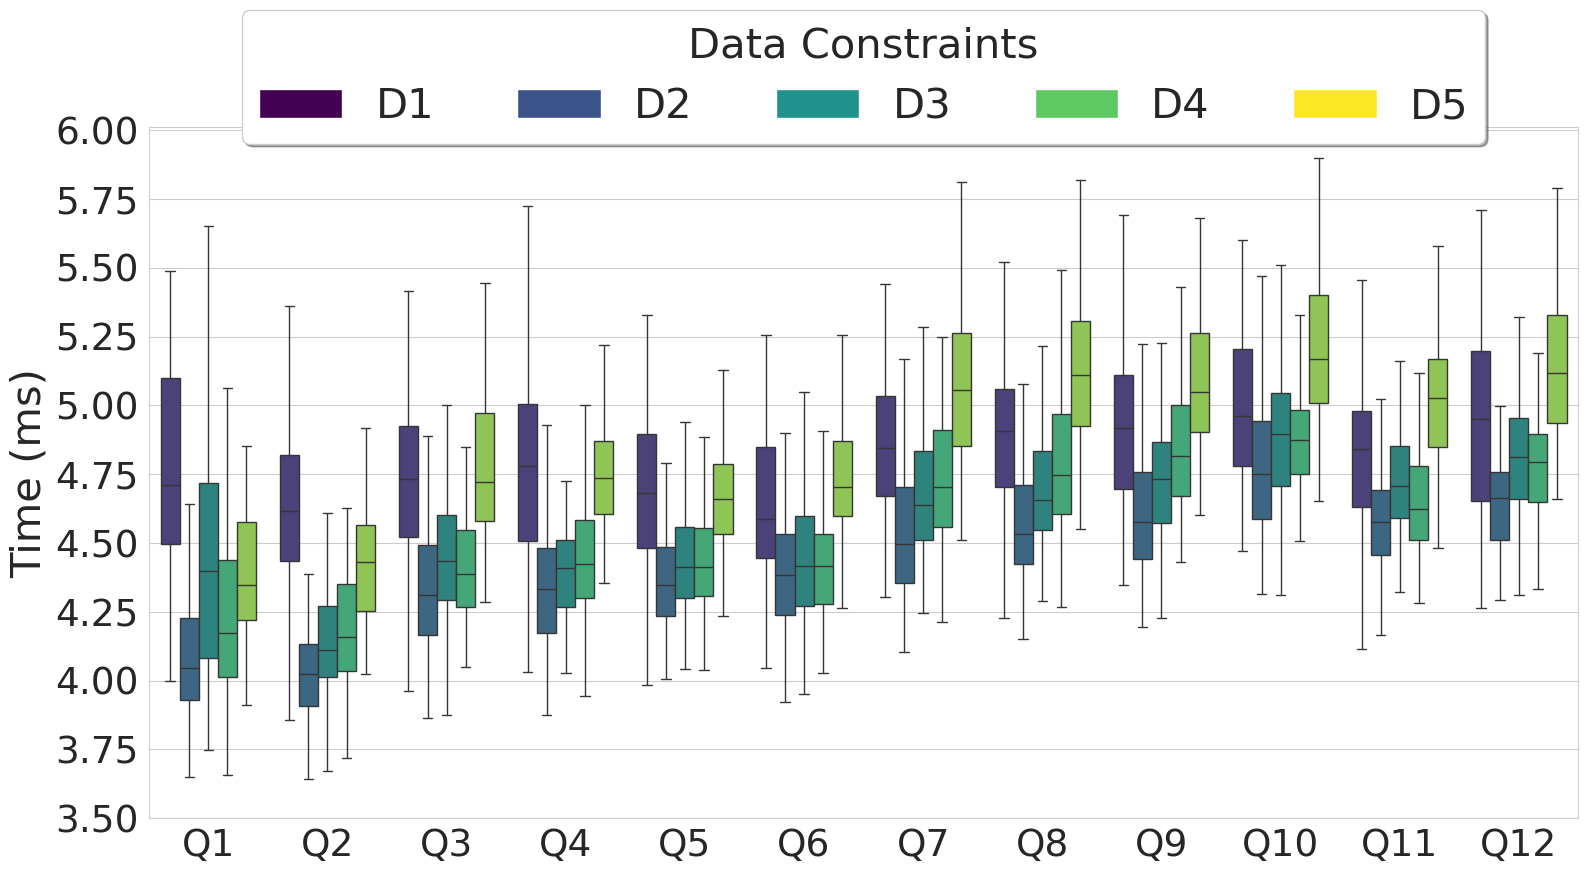

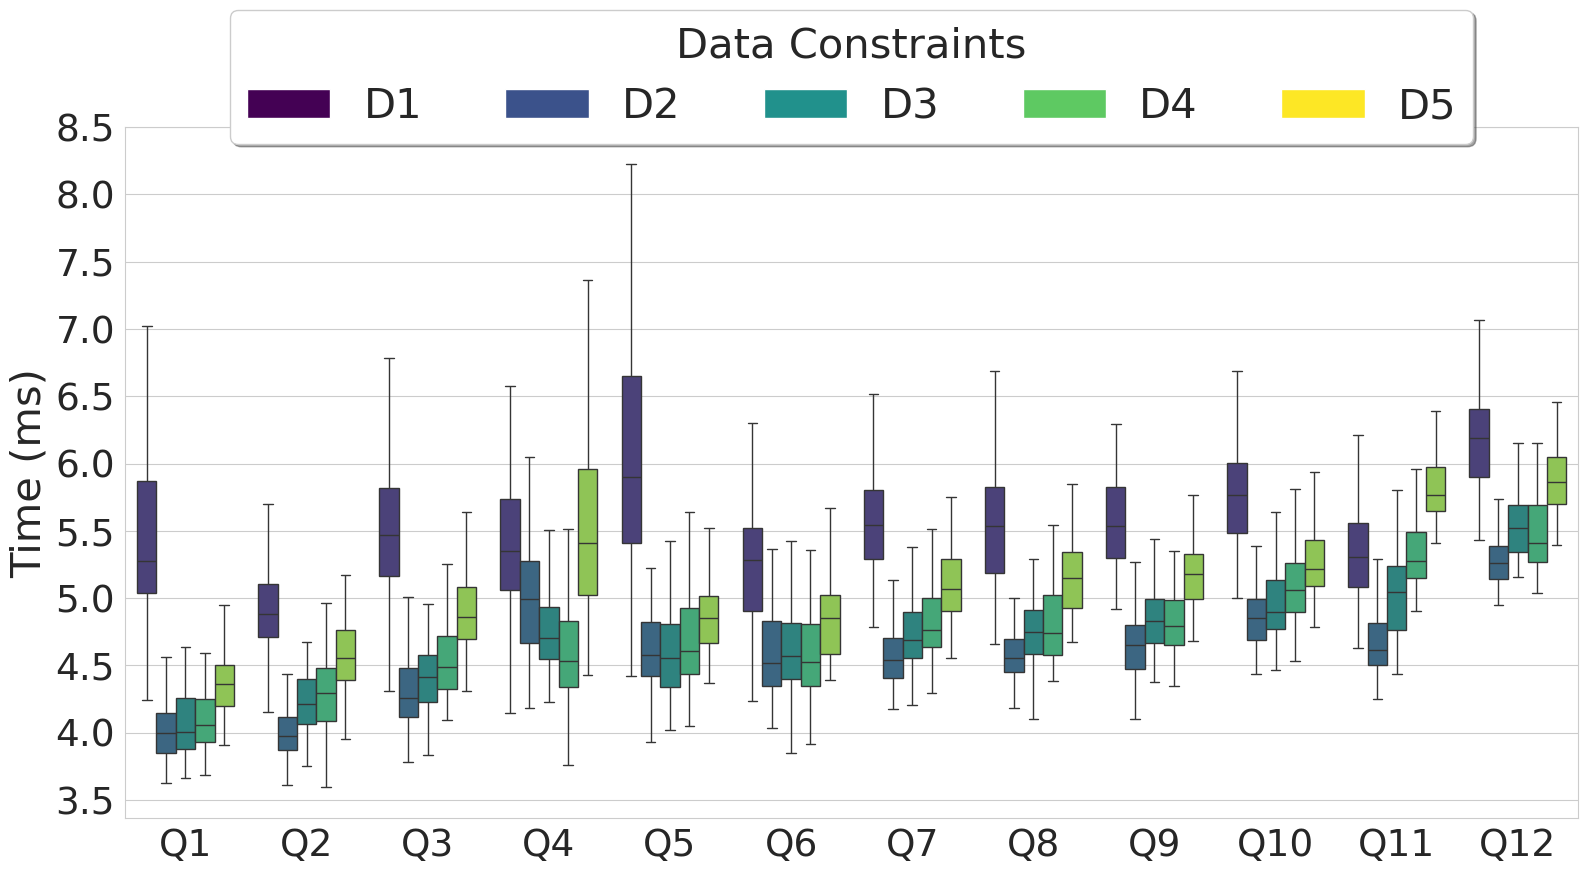

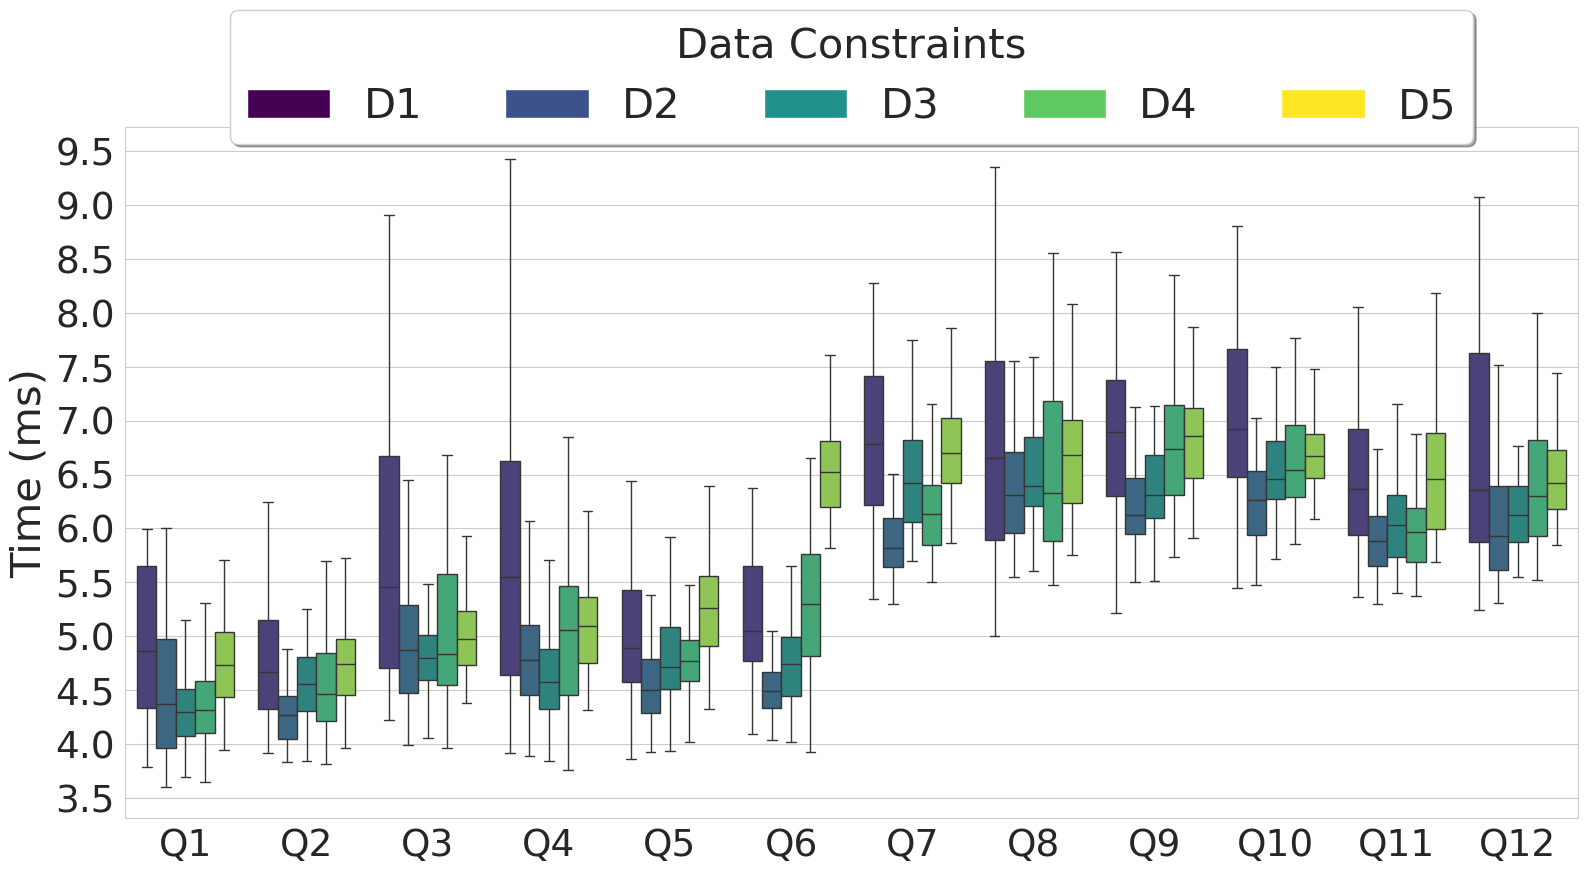

In [79]:
plot_single_dataset_boxplot("pokec/pokec_statistic.pkl", ds="Pokec")
plot_single_dataset_boxplot("telecom/telecom_statistic.pkl", ds="Telecom")
plot_single_dataset_boxplot("ldbc10/ldbc10_statistic.pkl", ds="LDBC10")
plot_single_dataset_boxplot("ldbc01/ldbc01_statistic.pkl", ds="LDBC01")
plot_single_dataset_boxplot("icij-leak/icij_leak_static.pkl", ds="ICIJ")
plot_single_dataset_boxplot("paradise/icij_paradise_statistic.pkl", ds="Paradise")



